# Fault detection

We'll consider a problem of identifying faults that have occurred in a system based on sensor measurements of system performance.

# Topic references
- [Samar, Sikandar, Dimitry Gorinevsky, and Stephen Boyd. "Likelihood Bounds for Constrained Estimation with Uncertainty." Decision and Control, 2005 and 2005 European Control Conference. CDC-ECC'05. 44th IEEE Conference on. IEEE, 2005.](http://web.stanford.edu/~boyd/papers/pdf/map_bounds.pdf)

# Problem statement

Each of $n$ possible faults occurs independently with probability $p$.
The vector $x \in \lbrace 0,1 \rbrace^{n}$ encodes the fault occurrences, with $x_i = 1$ indicating that fault $i$ has occurred.
System performance is measured by $m$ sensors.
The sensor output is
\begin{equation}
y = Ax + v = \sum_{i=1}^n a_i x_i + v,
\end{equation}
where $A \in \mathbf{R}^{m \times n}$ is the sensing matrix with column $a_i$ being the **fault signature** of fault $i$,
and $v \in \mathbf{R}^m$ is a noise vector where $v_j$ is Gaussian with mean 0 and variance $\sigma^2$.

The objective is to guess $x$ (which faults have occurred) given $y$ (sensor measurements).

We are interested in the setting where $n > m$, that is, when we have more possible faults than measurements.
In this setting, we can expect a good recovery when the vector $x$ is sparse.
This is the subject of compressed sensing.

# Solution approach
To identify the faults, one reasonable approach is to choose $x \in \lbrace 0,1 \rbrace^{n}$ to minimize the negative log-likelihood function

\begin{equation}
\ell(x) = \frac{1}{2 \sigma^2} \|Ax-y\|_2^2 +  \log(1/p-1)\mathbf{1}^T x + c.
\end{equation}

However, this problem is nonconvex and NP-hard, due to the constraint that $x$ must be Boolean.

To make this problem tractable, we can relax the Boolean constraints and instead constrain $x_i \in [0,1]$.

The optimization problem

\begin{array}{ll}
\mbox{minimize} &  \|Ax-y\|_2^2 + 2 \sigma^2 \log(1/p-1)\mathbf{1}^T x\\
\mbox{subject to} &  0 \leq x_i \leq 1, \quad i=1, \ldots n
\end{array}

is convex.
We'll refer to the solution of the convex problem as the **relaxed ML** estimate.

By taking the relaxed ML estimate of $x$ and rounding the entries to the nearest of 0 or 1, we recover a Boolean estimate of the fault occurrences.

# Example

We'll generate an example with $n = 2000$ possible faults, $m = 200$ measurements, and fault probability $p = 0.01$.
We'll choose $\sigma^2$ so that the signal-to-noise ratio is 5.
That is,
\begin{equation}
\sqrt{\frac{\mathbf{E}\|Ax \|^2_2}{\mathbf{E} \|v\|_2^2}} = 5.
\end{equation}

In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

n = 2000
m = 200
p = 0.01
snr = 5

sigma = np.sqrt(p*n/(snr**2))
A = np.random.randn(m,n)

x_true = (np.random.rand(n) <= p).astype(np.int)
v = sigma*np.random.randn(m)

y = A.dot(x_true) + v

Below, we show $x$, $Ax$ and the noise $v$.

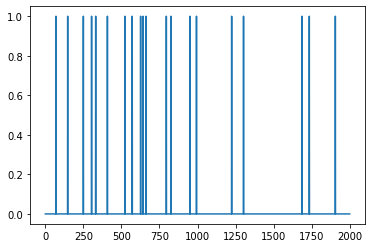

In [2]:
plt.plot(range(n),x_true)

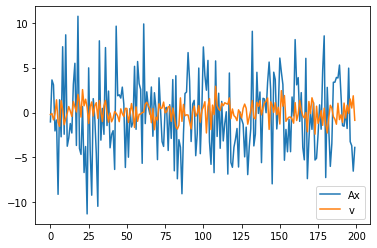

In [3]:
plt.plot(range(m), A.dot(x_true),range(m),v)
plt.legend(('Ax','v'))

# Recovery

We solve the relaxed maximum likelihood problem with CVXPY and then round the result to get a Boolean solution.

In [4]:
%%time
import cvxpy as cp
x = cp.Variable(shape=n)
tau = 2*cp.log(1/p - 1)*sigma**2
obj = cp.Minimize(cp.sum_squares(A*x - y) + tau*cp.sum(x))
const = [0 <= x, x <= 1]
cp.Problem(obj,const).solve(verbose=True)
print("final objective value: {}".format(obj.value))

# relaxed ML estimate
x_rml = np.array(x.value).flatten()

# rounded solution
x_rnd = (x_rml >= .5).astype(int)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 2200, constraints m = 4200
          nnz(P) + nnz(A) = 404400
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -5.3751e+04   1.27e+01   5.58e+04   1.00e-01   1.48e-01s
 200   1.6062e+02   1.67e-02   3.79e-02   1.00e-01   3.89e-01s
 400   1.7725e+02   8.20e-03   2.96e-02 

# Evaluation

We define a function for computing the estimation errors, and a function for plotting $x$, the relaxed ML estimate, and the rounded solutions.

In [0]:
import matplotlib

def errors(x_true, x, threshold=.5):
    '''Return estimation errors.
    
    Return the true number of faults, the number of false positives, and the number of false negatives.
    '''
    n = len(x_true)
    k = sum(x_true)
    false_pos = sum(np.logical_and(x_true < threshold, x >= threshold))
    false_neg = sum(np.logical_and(x_true >= threshold, x < threshold))
    return (k, false_pos, false_neg)

def plotXs(x_true, x_rml, x_rnd, filename=None):
    '''Plot true, relaxed ML, and rounded solutions.'''
    matplotlib.rcParams.update({'font.size': 14})
    xs = [x_true, x_rml, x_rnd]
    titles = ['x_true', 'x_rml', 'x_rnd']

    n = len(x_true)
    k = sum(x_true)

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))

    for i,x in enumerate(xs):
            ax[i].plot(range(n), x)
            ax[i].set_title(titles[i])
            ax[i].set_ylim([0,1])
            
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        
    return errors(x_true, x_rml,.5)

We see that out of 20 actual faults, the rounded solution gives perfect recovery with 0 false negatives and 0 false positives.

(20, 0, 0)

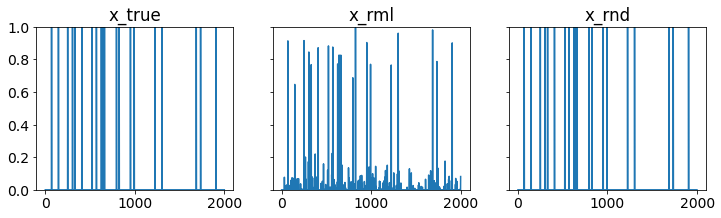

In [6]:
plotXs(x_true, x_rml, x_rnd, 'fault.pdf')

# Same problem, but with pytorch

In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

n = 2000
m = 200
p = 0.01
snr = 5

sigma = np.sqrt(p*n/(snr**2))
A = np.random.randn(m,n)

x_true = (np.random.rand(n) <= p).astype(np.int)
v = sigma*np.random.randn(m)

y = A.dot(x_true) + v

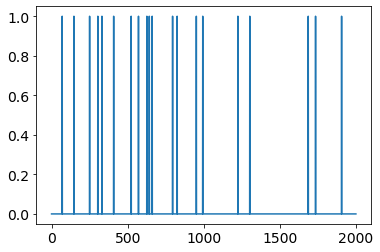

In [8]:
plt.plot(range(n),x_true)

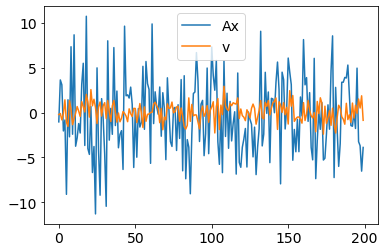

In [9]:
plt.plot(range(m), A.dot(x_true),range(m),v)
plt.legend(('Ax','v'))

In [10]:
%%time
import torch
import torch.nn as nn


class FaultDet(nn.Module):
    def __init__(self, n):
        super(FaultDet, self).__init__()
        self.n = n
        self.x = nn.Parameter(torch.zeros(self.n))
    
    def forward(self):
        return self.x


class FaultDetLoss(nn.Module):
    def __init__(self, tau):
        super().__init__()
        self.tau = tau
    
    def forward(self, x, A, y):
        at = torch.tensor(A, dtype=torch.float32)
        yt = torch.tensor(y)
        #print(at, x)
        #buf = torch.sum((at @ x - yt) ** 2)
        loss = torch.sum((at @ x - yt) ** 2) + torch.tensor(tau) * torch.sum(x)
        return loss


def solve_probl(model, loss, optim, scheduler, A, y, tau, epoch=1):
    for k in range(epoch):
        x = model()
        optim.zero_grad()
        scheduler.step()
        cur_loss = loss(x, A, y)
        cur_loss.backward()
        optim.step()
        # added constraint
        with torch.no_grad():
            for param in model.parameters():
                param.clamp_(0, 1)
        #print(cur_loss.detach().numpy())
    return x


tau = 2*np.log(1/p - 1)*sigma**2
model = FaultDet(n)
loss = FaultDetLoss(tau)
optim = torch.optim.Adam(model.parameters(),lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=200, gamma=0.1)
x_pred = solve_probl(model, loss, optim, scheduler, A, y, tau, epoch=200)
print(x_pred.detach().numpy())
x_rml = x_pred.detach().numpy()
x_rnd = (x_rml >= .5).astype(int)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[0.         0.         0.         ... 0.         0.         0.10762944]
CPU times: user 486 ms, sys: 31.7 ms, total: 517 ms
Wall time: 528 ms


In [0]:
import matplotlib

def errors(x_true, x, threshold=.5):
    '''Return estimation errors.
    
    Return the true number of faults, the number of false positives, and the number of false negatives.
    '''
    n = len(x_true)
    k = sum(x_true)
    false_pos = sum(np.logical_and(x_true < threshold, x >= threshold))
    false_neg = sum(np.logical_and(x_true >= threshold, x < threshold))
    return (k, false_pos, false_neg)

def plotXs(x_true, x_rml, x_rnd, filename=None):
    '''Plot true, relaxed ML, and rounded solutions.'''
    matplotlib.rcParams.update({'font.size': 14})
    xs = [x_true, x_rml, x_rnd]
    titles = ['x_true', 'x_rml', 'x_rnd']

    n = len(x_true)
    k = sum(x_true)

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))

    for i,x in enumerate(xs):
            ax[i].plot(range(n), x)
            ax[i].set_title(titles[i])
            ax[i].set_ylim([0,1])
            
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        
    return errors(x_true, x_rml,.5)

(20, 0, 0)

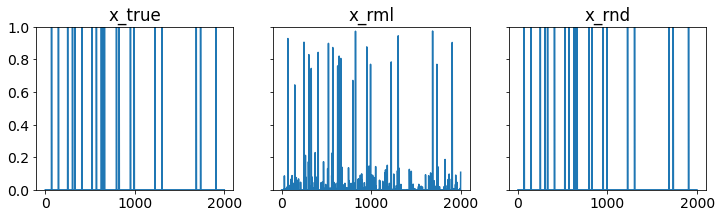

In [12]:
plotXs(x_true, x_rml, x_rnd, 'fault.pdf')